# **Art Classifier**

## **Non Structured Data**

This project has been done by:

|Name                    |Email                              |
|------------------------|-----------------------------------|
|Jorge Ayuso Martínez    |jorgeayusomartinez@alu.comillas.edu|
|Carlota Monedero Herranz|carlotamoh@alu.comillas.edu        |
|José Manuel Vega Gradit |josemanuel.vega@alu.comillas.edu   |

First of all, let's load the required libraries in order to run the code:

In [21]:
import os
import numpy as np

import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import seaborn as sns

Now let's see how our data is structured:

In [7]:
# Root folder
base_dir = "./data"

In [8]:
# Train folder
train_dir = os.path.join(base_dir, "train")

# Validation folder
validation_dir = os.path.join(base_dir, "validation")

# Test folder
test_dir = os.path.join(base_dir, "test")

In [9]:
for path in os.walk(base_dir):
    for folder in path[1]:
        if ".ipynb_checkpoints" in folder:
            os.rmdir(os.path.join(path[0], folder))

Let's also see how many images there are for each class in the training, validation and test set.

In [10]:
# Number of classes
n_classes = len(os.listdir(train_dir))
print(f"Number of classes: {n_classes}")

# Get existing classes
classes = os.listdir(train_dir)
print("Existing classes:\n")
classes

Number of classes: 4
Existing classes:



['Renaissance', 'Realism', 'Baroque', 'Romanticism']

In [11]:
# Training
print("Number of images per class in Training set:")
print("="*50)
for cl in classes:
    n_images = len(os.listdir(os.path.join(train_dir, cl)))
    print(f"{cl}: {n_images}")

Number of images per class in Training set:
Renaissance: 4000
Realism: 4000
Baroque: 4000
Romanticism: 4000


In [12]:
# Validation
print("Number of images per class in Validation set:")
print("="*50)
for cl in classes:
    n_images = len(os.listdir(os.path.join(validation_dir, cl)))
    print(f"{cl}: {n_images}")

Number of images per class in Validation set:
Renaissance: 500
Realism: 500
Baroque: 500
Romanticism: 500


In [13]:
# Test
print("Number of images per class in Test set:")
print("="*50)
for cl in classes:
    n_images = len(os.listdir(os.path.join(test_dir, cl)))
    print(f"{cl}: {n_images}")

Number of images per class in Test set:
Renaissance: 500
Realism: 500
Baroque: 500
Romanticism: 500


We'll also create the directory, if not created yet, where the models will be saved:

In [14]:
# Create directory where to save the models created
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

## **1. Base model**

The first model we will create is a simple CNN. This will help us to have a general idea of how a very simple model would perform classifying art images, and try to improve this model by, for instance: 

* Upsampling the training dataset using Data Augmentation.
* Using regularization techniques such as $𝓛_1$, $𝓛_2$ or dropout.
* Incrementing the number of parameters of the CNN.
* Using pre-trained models (Transfer-Learning and Fine-Tuning).

### 1.1. Model structure

Let's first create the model structure:

In [15]:
model = models.Sequential()
# 1st Convolution Layer
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(256, 256, 3)
                        )
)
# 1st Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 2nd Convolution Layer
model.add(layers.Conv2D(64, 
                        (3, 3), 
                        activation='relu'
                       )
         )
# 2nd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 3rd Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 3rd Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))
# 4th Convolution Layer
model.add(layers.Conv2D(128, 
                        (3, 3), 
                        activation='relu'
                        )
)
# 4th Pooling Layer
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))

Once the structure of the base model has been defined, let's see exactly how many parameters it has in order to have a better idea of how flexible this model is:

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

We'll use Adam as our optimizer since it is the most popular optimizer right now, as well as versatile (i.e., it can be used in multiple contexts).

In [17]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['acc']
)

### 1.2. Data preprocessing

A critical step when creating these kind of models is how the input data is preprocessed. These involves:

* Normalize the input by dividing each pixel by its maximum value (i.e, 255).
* Define the input size, which affects to the final model.
* Batch size: this is the number of images in each batch.

In [18]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(256, 256),
        batch_size=128,
        class_mode='categorical'
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=128,
        class_mode='categorical'
        )

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


Now let's take a look at the output of one of these generators (for instance, the training one):

In [19]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (128, 256, 256, 3)
labels batch shape: (128, 4)


*We can appreciate that...*

### 1.3. Training

Let's train the model:

We use [Early Stopping](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) to avoid *overfitting*, as well `ModelCheckpoint` to save the best model obtained during training:

In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(os.path.join("models", "base_model.h5"), monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [23]:
history = model.fit(
    train_generator,
    steps_per_epoch=125,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=15,
    callbacks = [es, mc]
      )

Epoch 1/100
 88/125 [====================>.........] - ETA: 1:26 - loss: 1.2688 - acc: 0.4259

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


125/125 [==============================] - ETA: 0s - loss: 1.2337 - acc: 0.4480
Epoch 1: val_loss improved from inf to 1.16152, saving model to base_model.h5
125/125 [==============================] - 340s 3s/step - loss: 1.2337 - acc: 0.4480 - val_loss: 1.1615 - val_acc: 0.5000
Epoch 2/100
125/125 [==============================] - ETA: 0s - loss: 1.1020 - acc: 0.5302
Epoch 2: val_loss improved from 1.16152 to 1.09395, saving model to base_model.h5
125/125 [==============================] - 328s 3s/step - loss: 1.1020 - acc: 0.5302 - val_loss: 1.0939 - val_acc: 0.5557
Epoch 3/100
125/125 [==============================] - ETA: 0s - loss: 1.0474 - acc: 0.5537
Epoch 3: val_loss improved from 1.09395 to 1.04382, saving model to base_model.h5
125/125 [==============================] - 326s 3s/step - loss: 1.0474 - acc: 0.5537 - val_loss: 1.0438 - val_acc: 0.5589
Epoch 4/100
125/125 [==============================] - ETA: 0s - loss: 0.9984 - acc: 0.5753
Epoch 4: val_loss improved from 1.04

Now let's load the best model found:

In [25]:
# load the saved model
base_model = load_model(os.path.join("models", "base_model.h5"))

### 1.4. Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [27]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

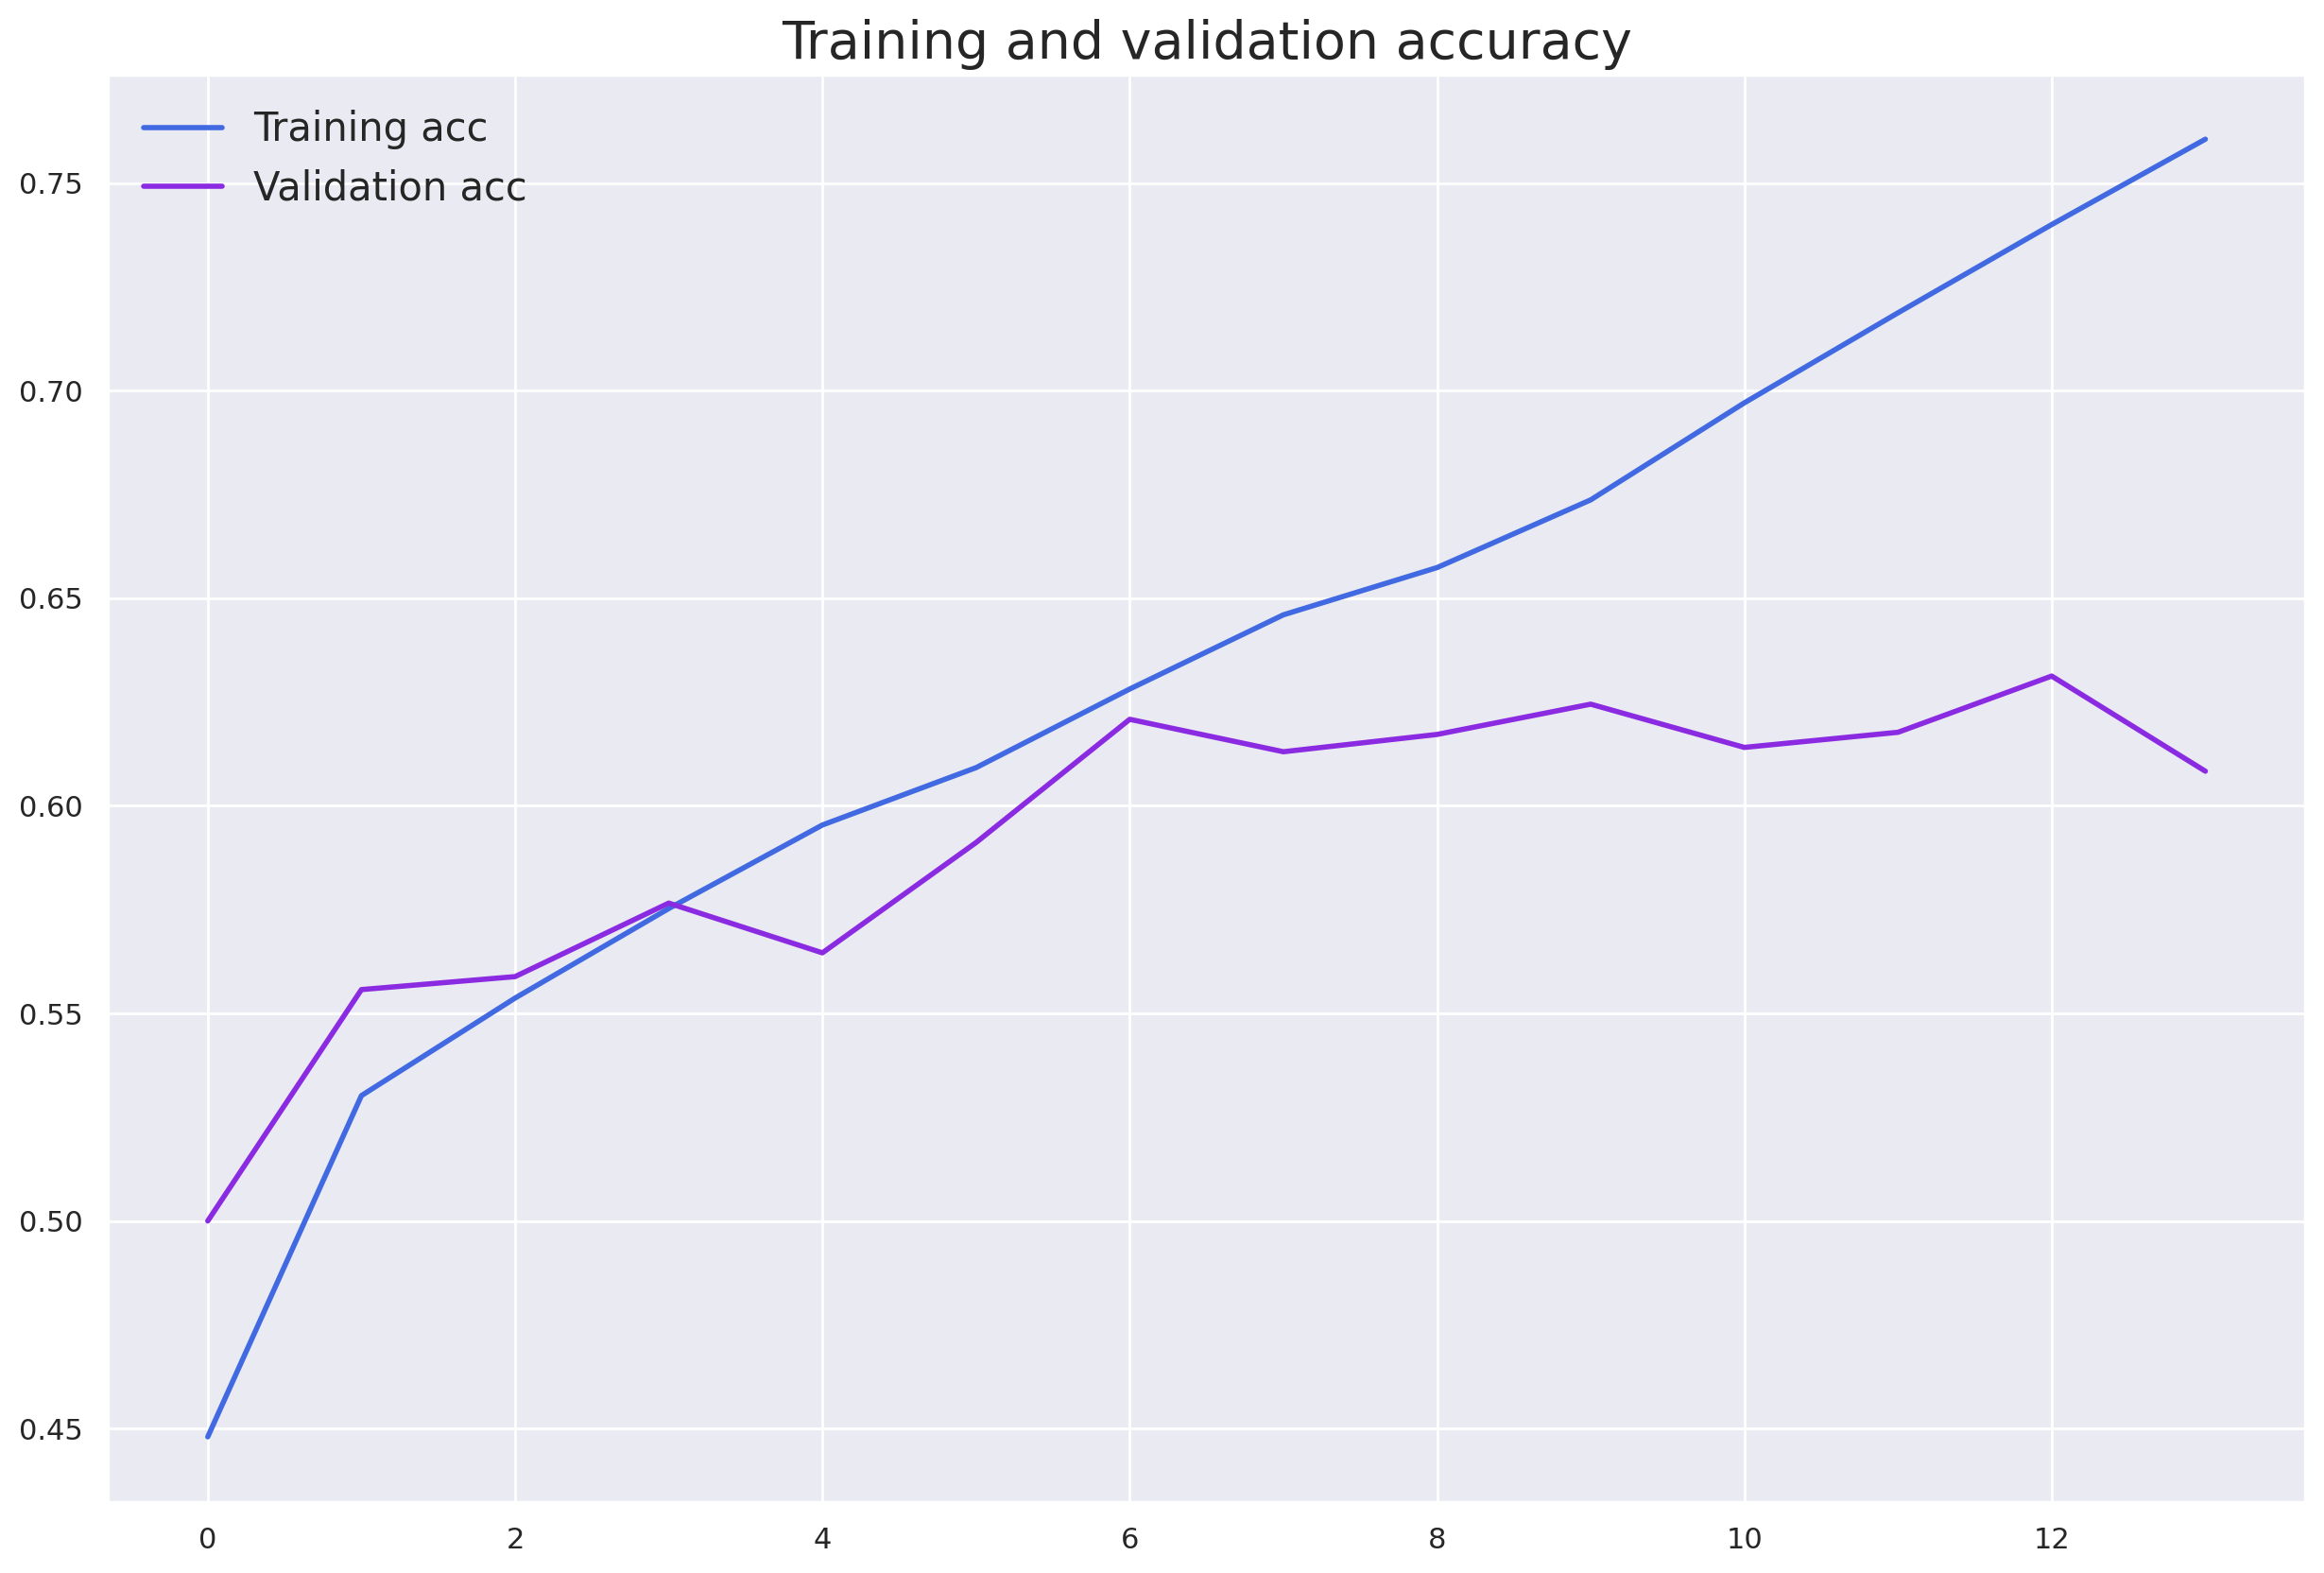

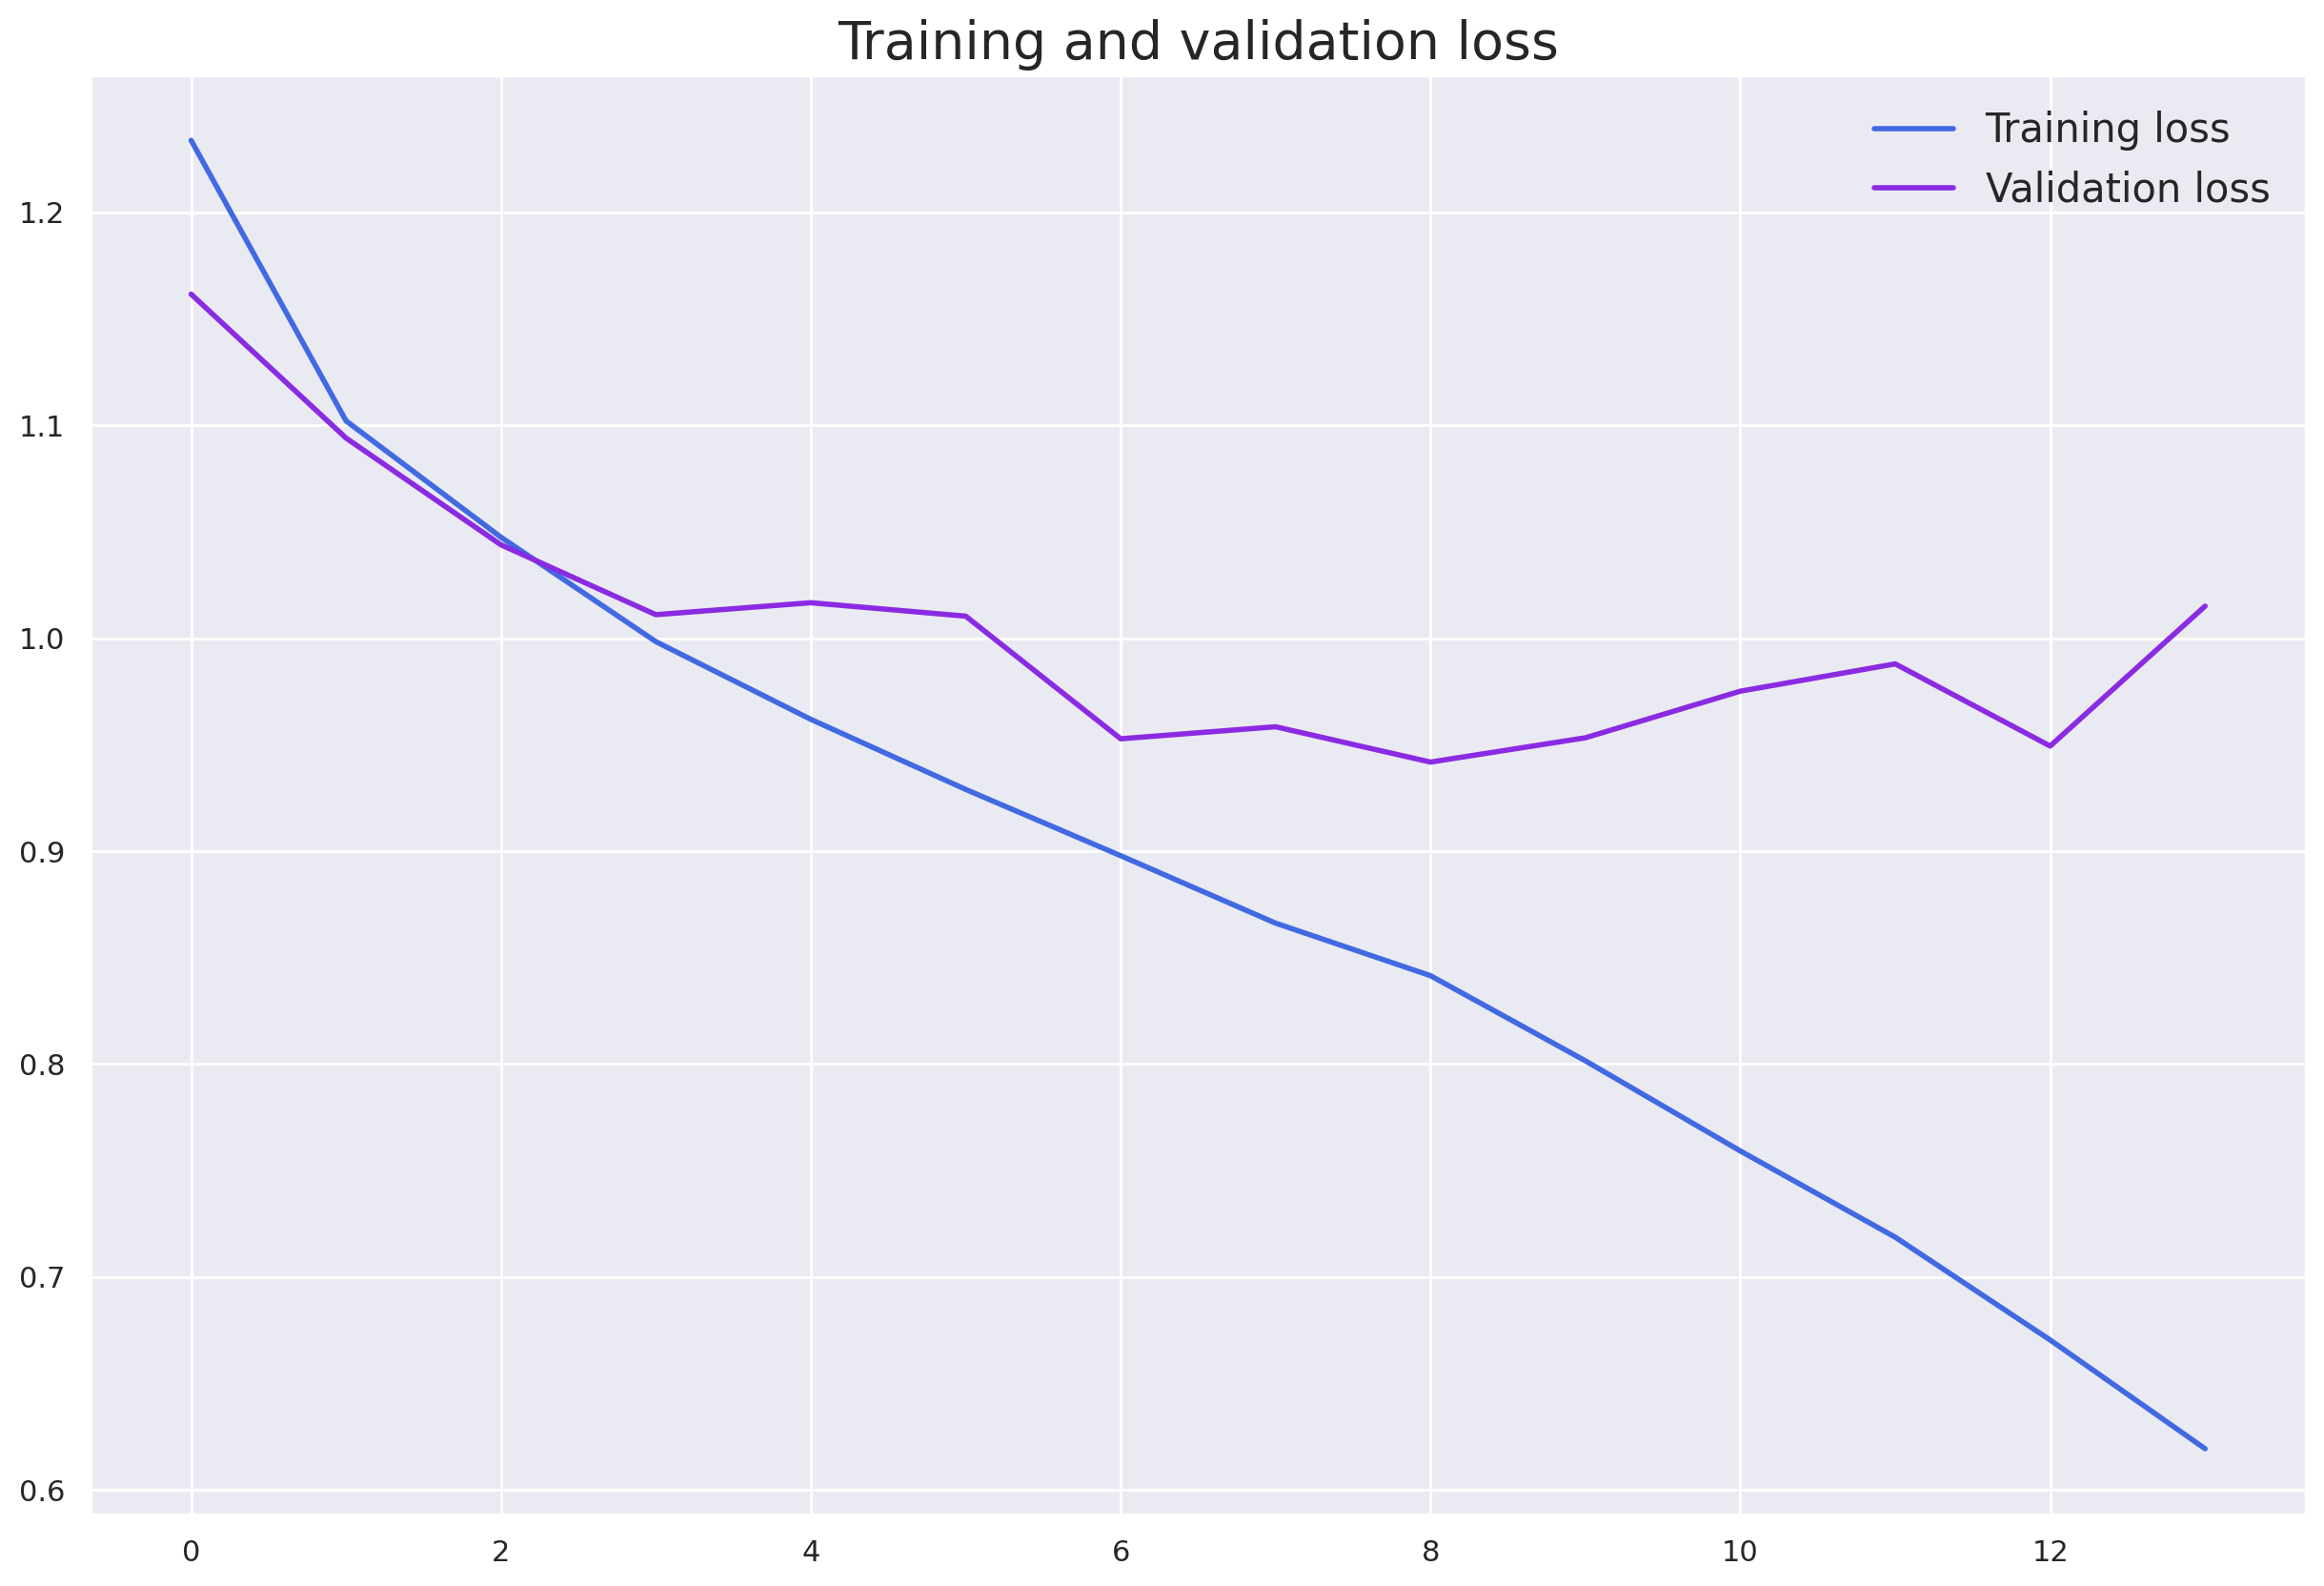

In [40]:
sns.set_theme()

plt.figure(figsize=(15,10), dpi=200)

plt.plot(epochs, acc, 'royalblue', linewidth=2, label='Training acc')
plt.plot(epochs, val_acc, 'blueviolet', linewidth=2, label='Validation acc')
plt.title('Training and validation accuracy', fontsize=20)
plt.legend(frameon=False, fontsize=15)

plt.show()

plt.figure(figsize=(15,10), dpi=200)

plt.plot(epochs, loss, 'royalblue', linewidth=2, label='Training loss')
plt.plot(epochs, val_loss, 'blueviolet', linewidth=2, label='Validation loss')
plt.title('Training and validation loss', fontsize=20)
plt.legend(frameon=False, fontsize=15)

plt.show()

In [41]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=128,
        class_mode='categorical'
        )

Found 2000 images belonging to 4 classes.


In [42]:
model.evaluate(test_generator)

16/16 [==============================] - 38s 2s/step - loss: 1.0054 - acc: 0.6050


[1.0053592920303345, 0.6050000190734863]

*Comments about how those metrics have evolved...*